# UK GENDER WAGE GAP 

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy import stats
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.style.use('ggplot')

In [31]:
# create dataframe
data = pd.read_csv("UK-Gender-Pay-Gap-2018-19.csv",index_col=0)
data = pd.DataFrame(data)

Lets look at our data 

In [35]:
data

Company Num         SIC code                           Organisation  \
0         226143            85310        "Bryanston School",Incorporated   
1       SC016876            47730   "RED BAND" CHEMICAL COMPANY, LIMITED   
2        3951948            61900                            118 LIMITED   
3       10530651            78300                      123 EMPLOYEES LTD   
4        4104101  85200,\r\n85310                             1509 GROUP   
...          ...              ...                                    ...   
4576     1107406            47110                  ICELAND FOODS LIMITED   
4577     8776727            10890                     ICHIBAN UK LIMITED   
4578      282648            30300          ICON AEROSPACE TECHNOLOGY LTD   
4579     2541764            72190  ICON CLINICAL RESEARCH (U.K.) LIMITED   
4580     4399985            96090                       Ics Umbrella Ltd   

                                                Address  \
0     Bryanston House,\r\nBlandford,\r\nDorset,\r\nU...   
1     19 Smith's Place,\r\nLeith Walk,\r\nEdinburgh,...   
2     Fusion Point,\r\nDumballs Road,\r\nCardiff,\r\...   
3     34 Roundhay Road,\r\nLeeds,\r\nEngland,\r\nLS7...   
4     Royal Grammar School, High Street,\r\nGuildfor...   
...                                                 ...   
4576  Second Avenue,\r\nDeeside Industrial Park,\r\n...   
4577  Barrack Farm,\r\nWarren Lane,  Woolpit,\r\nBur...   
4578  Victoria Works, Thrumpton Lane,\r\nRetford,\r\...   
4579  Concept House,\r\n6 Stoneycroft Rise,\r\nChand...   
4580  2 Mannin Way,\r\nLancaster,\r\nUnited Kingdom,...   

                          Organisation name  Male bottom quartile %  \
0           "Bryanston School",Incorporated                   32.40   
1      "RED BAND" CHEMICAL COMPANY, LIMITED                   31.60   
2                               118 LIMITED                   41.00   
3                         123 EMPLOYEES LTD                    0.00   
4                                1509 GROUP                   38.10   
...                                     ...                     ...   
4576                  ICELAND FOODS LIMITED                   29.50   
4577                     ICHIBAN UK LIMITED                   62.10   
4578          ICON AEROSPACE TECHNOLOGY LTD                   75.00   
4579  ICON CLINICAL RESEARCH (U.K.) LIMITED                   15.80   
4580                       Ics Umbrella Ltd                   65.00   

      Female bottom quartile %  Male lower middle quartile %  \
0                        67.60                         38.20   
1                        68.40                         12.70   
2                        59.00                         45.00   
3                       100.00                          2.00   
4                        61.90                         43.60   
...                        ...                           ...   
4576                     70.50                         39.60   
4577                     37.90                         65.50   
4578                     25.00                         75.00   
4579                     84.20                         23.70   
4580                     35.00                         56.00   

      Female lower middle quartile %  Male upper middle quartile %  ...  \
0                              61.80                         44.90  ...   
1                              87.30                         11.60  ...   
2                              55.00                         50.00  ...   
3                              98.00                         17.00  ...   
4                              56.40                         48.40  ...   
...                              ...                           ...  ...   
4576                           60.40                         54.90  ...   
4577                           34.50                         43.70  ...   
4578                           25.00                         73.50  ...   
4579       

The data contains 25 columns and 4581 rows. 

The lower, top and middle quartile refers to the percentage of men and women in the lower, top and middle quartile of the pay scale. 

In [36]:
# check if any data is missing 
data.isna().any()

Company Num                                   True
SIC code                                      True
Organisation                                 False
Address                                       True
Organisation name                            False
Male bottom quartile %                       False
Female bottom quartile %                     False
Male lower middle quartile %                 False
Female lower middle quartile %               False
Male upper middle quartile %                 False
Female upper middle quartile %               False
Male top quartile %                          False
Female top quartile %                        False
Mean wage difference %                       False
Median wage difference %                     False
Mean bonus difference %                      False
Median bonus difference %                    False
Male bonus %                                 False
Female bonus %                               False
URL to public gender pay gap in

In [37]:
# convert datatypes
data['Male bonus %'] = data['Male bonus %'].astype(float)
data['SIC code'] = data['SIC code'].astype(str)

So the data is initially quite straightforward and cleaned. 

Just looking at the first few rows of the data, it seems like there is a slight overweight of female employees in the bottom and men in the top, as well as a slight overweight of men getting paid more and who are getting more bonusses. 
But what is not clear is what that tells about the different sectors and if there is a difference in the wage gap between sectors. I want to interrogate if there is a correlation between the inequity in the central tendencies of the wage gaps. 

For each company entry the dataset provides the SIC codes: Five digits code that indicate the sector the company is registrered in.

However, these numbers doesn't reveal much, unless we load in the strings for what these SIC codes actually stand for. Therefore, I am going to create a new feature in the dataset containing that information. 

In order to do this, I create a new dataframe for the SIC codes downloaded from here: https://www.gov.uk/government/publications/standard-industrial-classification-of-economic-activities-sic

In [48]:
# create new dataframe. 
sic = pd.read_csv('SIC07_CH_condensed_list_en.csv') 
sic = pd.DataFrame(sic)

# look at the data
print(sic.shape)
print(sic.columns,'\n')
print(sic.isna().any(),'\n')
print(sic['SIC Code'])

(731, 2)
Index(['SIC Code', 'Description'], dtype='object') 

SIC Code       False
Description    False
dtype: bool 

0       1110
1       1120
2       1130
3       1140
4       1150
       ...  
726    98000
727    98100
728    98200
729    99000
730    99999
Name: SIC Code, Length: 731, dtype: int64


In [38]:
# look at the SIC codes from the original dataset 
print(data['SIC code'][300:310],'\n')
# get amount of unique values in the column 
unique_values = data['SIC code'].unique()
print('There are',len(unique_values), 'unique values in the SIC codes column')


300                                  73110
301                                  71122
302              71122,\r\n71200,\r\n82990
303    49410,\r\n52103,\r\n52290,\r\n82920
304                        47520,\r\n47530
305                                   1130
306                                  46900
307                                  60200
308                                  21100
309                                  46310
Name: SIC code, dtype: object 

There are 1160 unique values in the SIC codes column


So the SIC code column seems to have two different problems in terms of data formatting: Some of them are only four digits and some of them are in the format, '82990,\r\n8730', indicating that the company might belong to two different overlapping sectors. 

If we look at the csv file in Excel the values look like this: 
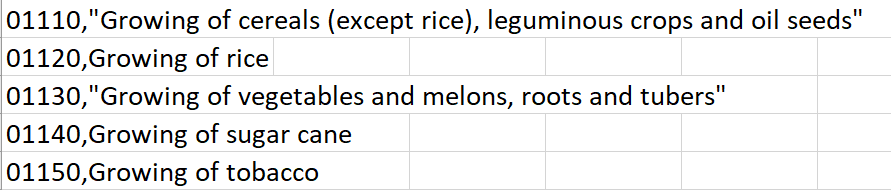

So the csv file with SIC codes from the UK government website that I am gonna use and introduce later holds data with 5 values, so I need to align that: 

1) I am gonna add a 0 at the end of the rows with only four digits

2) I am gonna turn the weird format into one value for simplicity. This is a choice that could obviously create disturbance in the data as information is lost, however I am choosing to do it this way, as we are still keeping some data intact. 


In [58]:
# extend four digit values 
data['SIC code'] = data['SIC code'].apply(lambda x: x + '0' if len(x)==4 else x)

# tokenize and add back to column
data['SIC code'] = data['SIC code'].apply(lambda x: x.split(',')[-1].strip())

In [12]:
# cell not needed anymore after new .csv 
#sic = pd.read_csv('SIC2007.csv',header = None)    # the second argument indicates that column names are missing and the first row is actual data values 
#sic = pd.DataFrame(sic)

# assign column names
#column_names = {sic.columns[0]:'SIC code',sic.columns[1]:'Sector'}
#sic = sic.rename(columns=column_names)
#print(sic.shape)
#print(sic.columns)
#print(sic.isna().any())

In [50]:
# fill in missing data 
sic.fillna('', inplace=True)
print(sic.isna().any())

SIC Code       False
Description    False
dtype: bool


Now I have two different dataframes each containing vital information. 

We want to merge the second column from the sic dataframe *if* the values of the first column in the sic dataframe matches the corresponding values in the column, 'SIC code' in the data dataframe.


In [59]:
# add a new column with rows of empty strings to the data dataframe to hold the SIC code descriptions
data['SIC Description'] = ''    # dtype = object

# convert type for columns 
sic['Description'] = sic['Description'].astype(str)
sic['SIC Code'] = sic['SIC Code'].astype(str)
data['SIC Description'] = data['SIC Description'].astype(str)

# iterate through the SIC codes and add their descriptions
for i, v in data.iterrows():    # this returns tuple of label and value 
 for x, k in sic.iterrows():
   if i not in sic.index:       # when there is no more rows in sic ends continue looping through data
      continue                 
   if sic['SIC Code'][x] == data['SIC code'][i]:        # check if sic is the same
    #sic_code = data['SIC Code'] 
    #if sic_code in sic['SIC Code']:
    data.loc[i, 'SIC Description'] = sic['Description'][x]      # add values from sic['Description'] to data dataframe
    found_match = True            # match found ! 
    if found_match != True:    
      #print("No match:", i, data.loc[i])
      break  # go to outer loop 
    else: 
      #print(f"SIC Description set for row {i}")
      break     # go to outer loop 

# DISTRIBUTIONS OF GENDER IN TOP AND BOTTOM QUARTILE & CENTRAL TENDENCIES

So now I got the SIC descriptions for each company merged into the original dataframe.

Now lets look at the mean wage difference in the different industries to see if there is any patterns. 


<Axes: xlabel='SIC Description'>

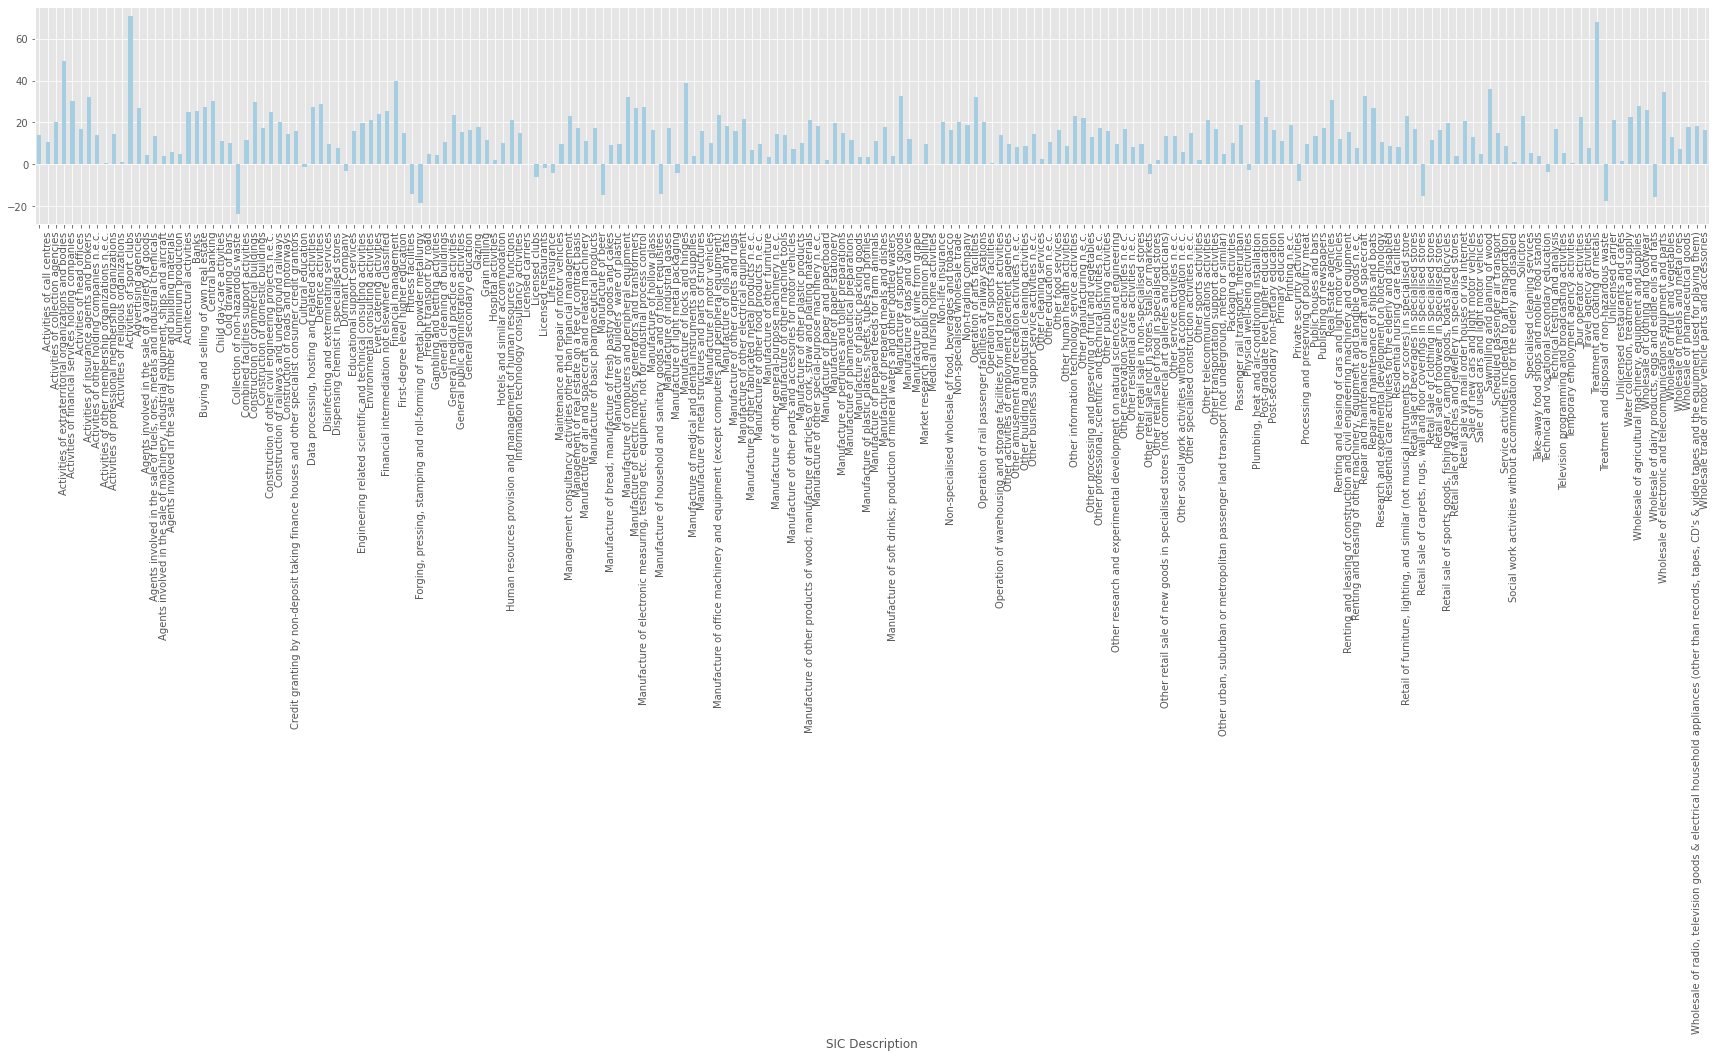

In [60]:
sector_meanwage = data.groupby('SIC Description')['Mean wage difference %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

Immediately, it seems like the mean wage difference is quite similar in each sector with a few sectors sticking out. 

Lets see what they are: 


In [16]:
top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors with the biggest mean wage difference is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors with the smallest mean wage difference is:\n', low_sectors)
                                

The top 5 sectors with the biggest mean wage difference is:
 SIC Description
Activities of sport clubs                                  70.65
Treatment and coating of metals                            68.20
Activities of extraterritorial organizations and bodies    49.40
Plumbing, heat and air-conditioning installation           40.20
Financial management                                       40.00
Name: Mean wage difference %, dtype: float64 

The top 5 sectors with the smallest mean wage difference is:
 SIC Description
Collection of non-hazardous waste                                              -23.8
Forging, pressing, stamping and roll-forming of metal; powder metallurgy       -18.7
Treatment and disposal of non-hazardous waste                                  -17.6
Wholesale of dairy products, eggs and edible oils and fats                     -15.7
Retail sale of carpets, rugs, wall and floor coverings in specialised stores   -15.3
Name: Mean wage difference %, dtype: float64


So from this we can see that some of the sectors in which the mean wage difference is highest are sectors like, 'Activities of sport clubs', 'Treatment and coating of metals' and 'Activities of extraterritorial organizations and bodies', which doesn't seem too surprising as these are usually fields that are associated with men. 

The negative values are quite intriguing. Because negative values in the dataset for the mean and median wages mean that the female employees earn more 
than the men, the numbers indicate that in sectors like, 'Collection of non-hazardous waste' and 'Forging, pressing, stamping and roll-forming of metal' women earn more on average than men. 

There is two main things, I notice here: The mean wage difference is significantly higher when the men are earning the most then when the women are earning the most. And the kind of sectors where women earn the most on average  feels kind of counterintuitive as these are usually industries dominated by men. 

If we look at the distribution of male and female employees in the bottom and top quartile of the workforce in each sector, we might understand why. 


The top 5 sectors with the most female employees in the top is:
 SIC Description
Child day-care activities                                                    86.800000
Residential nursing care facilities                                          86.160000
Medical nursing home activities                                              84.000000
Social work activities without accommodation for the elderly and disabled    82.350000
Residential care activities for the elderly and disabled                     81.345455
Name: Female top quartile %, dtype: float64 

The top 5 sectors with the least female employees in the top is:
 SIC Description
Activities of extraterritorial organizations and bodies                 0.0
Treatment and coating of metals                                         0.0
Construction of domestic buildings                                      2.2
Manufacture of household and sanitary goods and of toilet requisites    2.3
Repair and maintenance of ships and boats           

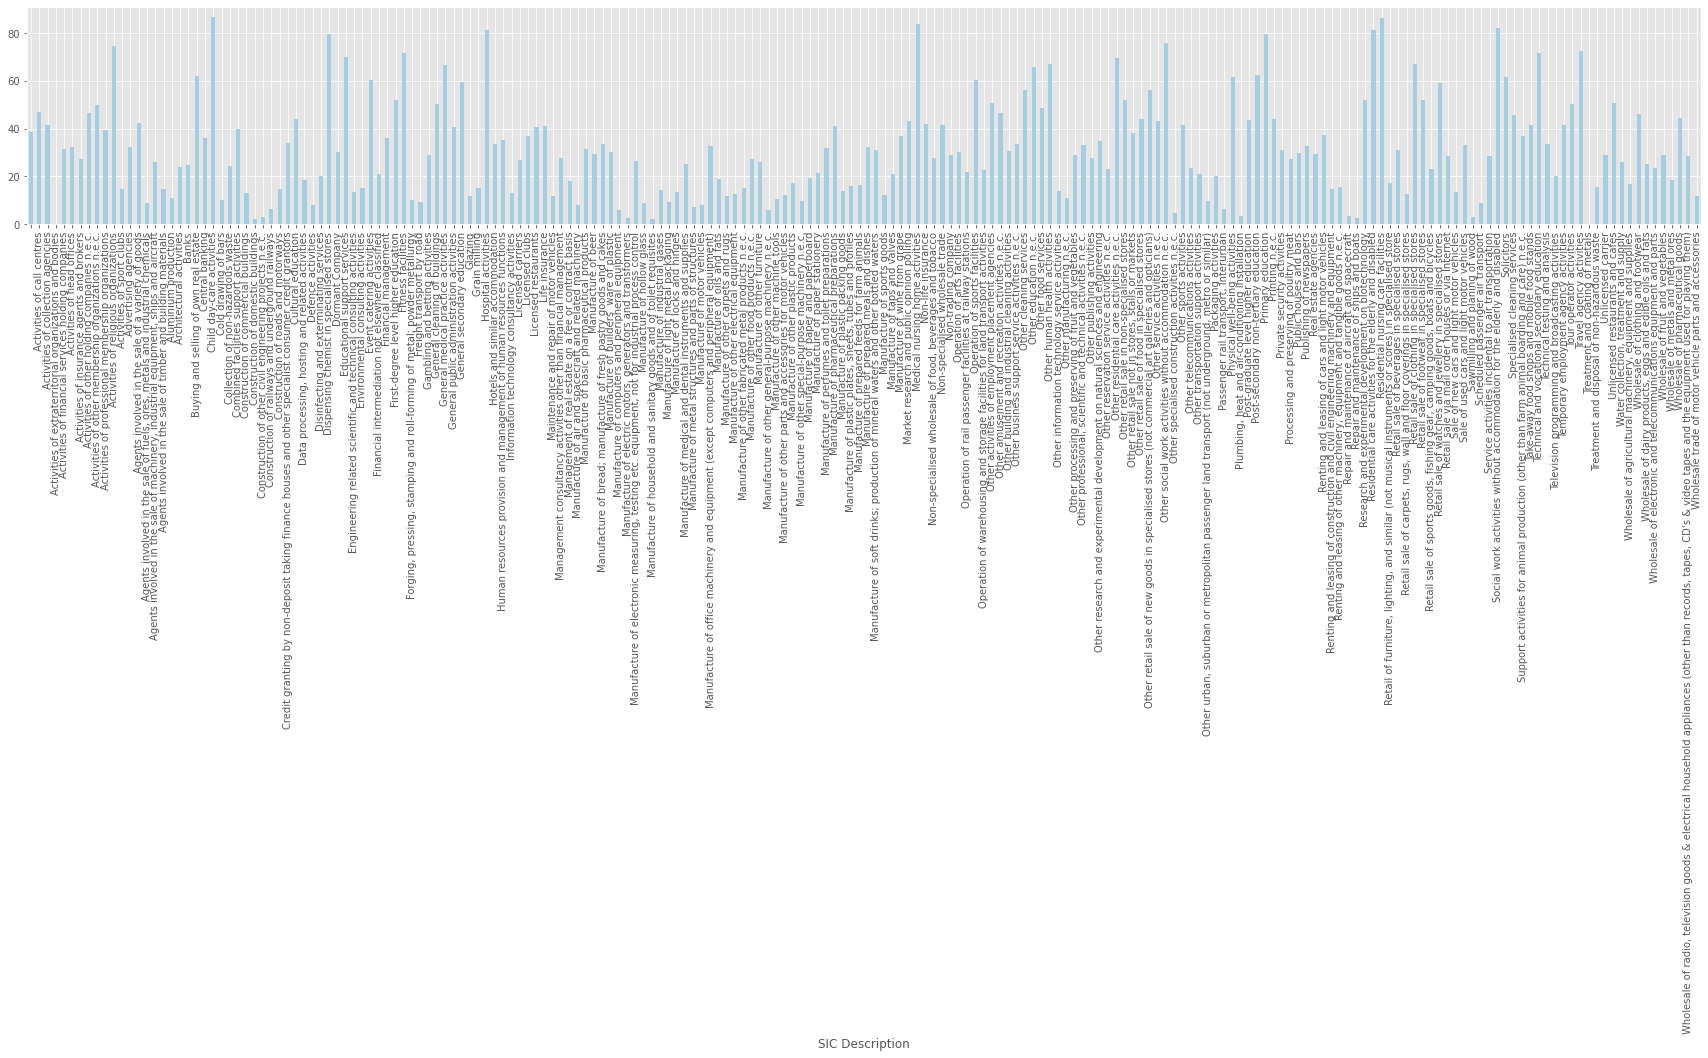

In [17]:
# FEMALE EMPLOYEES IN THE TOP QUARTILE 
sector_meanwage = data.groupby('SIC Description')['Female top quartile %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors with the most female employees in the top is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors with the least female employees in the top is:\n', low_sectors)

Here, we see how the sectors with the most female employees are sectors like 'Child day-care activities', 'Residential nursing care facilities' and 'Medical nursing home activites all of which are 'traditionally female' sectors. 

Moreover, several of the sectors where the mean wage difference is biggest overlap with the sectors where less female employees are in the top quartile of the employees, which could kind of be expected. In the sectors, 'Activities of extraterritorial organizations and bodies' and 'Treatment and coating of metal' there is no women at all in the top quartile - both sectors that place in the top 5 of mean wage difference. 

Lets see if the same pattern shows for the sectors with the most female employees in the bottom. 

The top 5 sectors with the most female employees in the bottom is:
 SIC Description
Treatment and coating of metals                               100.000
Retail sale of watches and jewellery in specialised stores     94.000
Child day-care activities                                      93.825
Event catering activities                                      90.100
Residential nursing care facilities                            86.260
Name: Female bottom quartile %, dtype: float64 

The top 5 sectors with the least female employees in the bottom is:
 SIC Description
Forging, pressing, stamping and roll-forming of metal; powder metallurgy         5.0
Retail sale of carpets, rugs, wall and floor coverings in specialised stores     5.7
Treatment and disposal of non-hazardous waste                                    7.7
Construction of domestic buildings                                              10.2
Manufacture of light metal packaging                                            10.5
Name: F

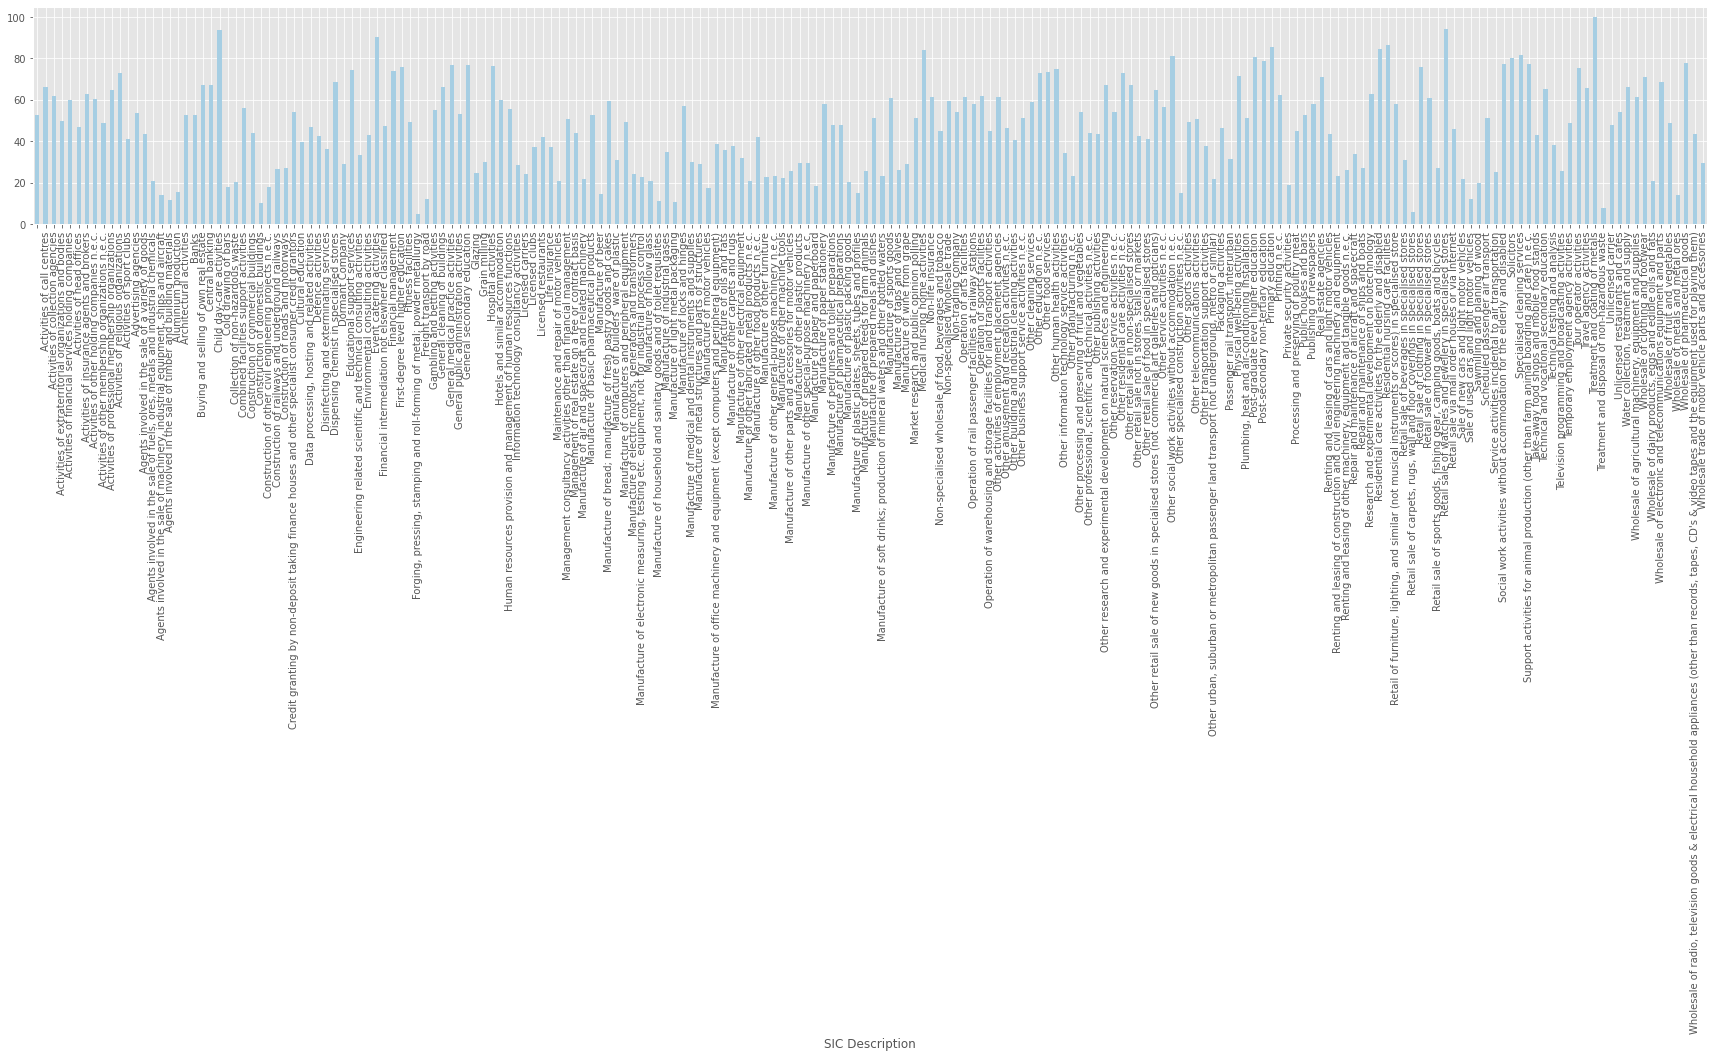

In [18]:
# FEMALE EMPLOYEES IN THE BOTTOM QUARTILE 
sector_meanwage = data.groupby('SIC Description')['Female bottom quartile %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors with the most female employees in the bottom is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors with the least female employees in the bottom is:\n', low_sectors)

Here the sector, 'Treatment and coating of metal' shows up again. In this sector there is exclusively female employees in the bottom quartile, contributing significantly to the wage gap. 

While the number of women placing in the bottom quartile of the wage distribution could be expected to be high in the sectors like 'Treatment of coating and metal' where the mean wage difference are highest, they also take up most of the employees in the bottom in sectors like, 'Child day-care activities' and 'Residential nursing care facilities' indicating that the wage gap also has its roots in the gender distribution across sectors. 


These numbers also tell something about the total number of women and men in the different sectors. 


Lets have a look at the men. 


The top 5 sectors with the most male employees in the top is:
 SIC Description
Activities of extraterritorial organizations and bodies                 100.0
Treatment and coating of metals                                         100.0
Construction of domestic buildings                                       97.8
Manufacture of household and sanitary goods and of toilet requisites     97.7
Repair and maintenance of ships and boats                                97.5
Name: Male top quartile %, dtype: float64 

The top 5 sectors with the least male employees in the top is:
 SIC Description
Child day-care activities                                                    13.200000
Residential nursing care facilities                                          13.840000
Medical nursing home activities                                              16.000000
Social work activities without accommodation for the elderly and disabled    17.650000
Residential care activities for the elderly and disabled   

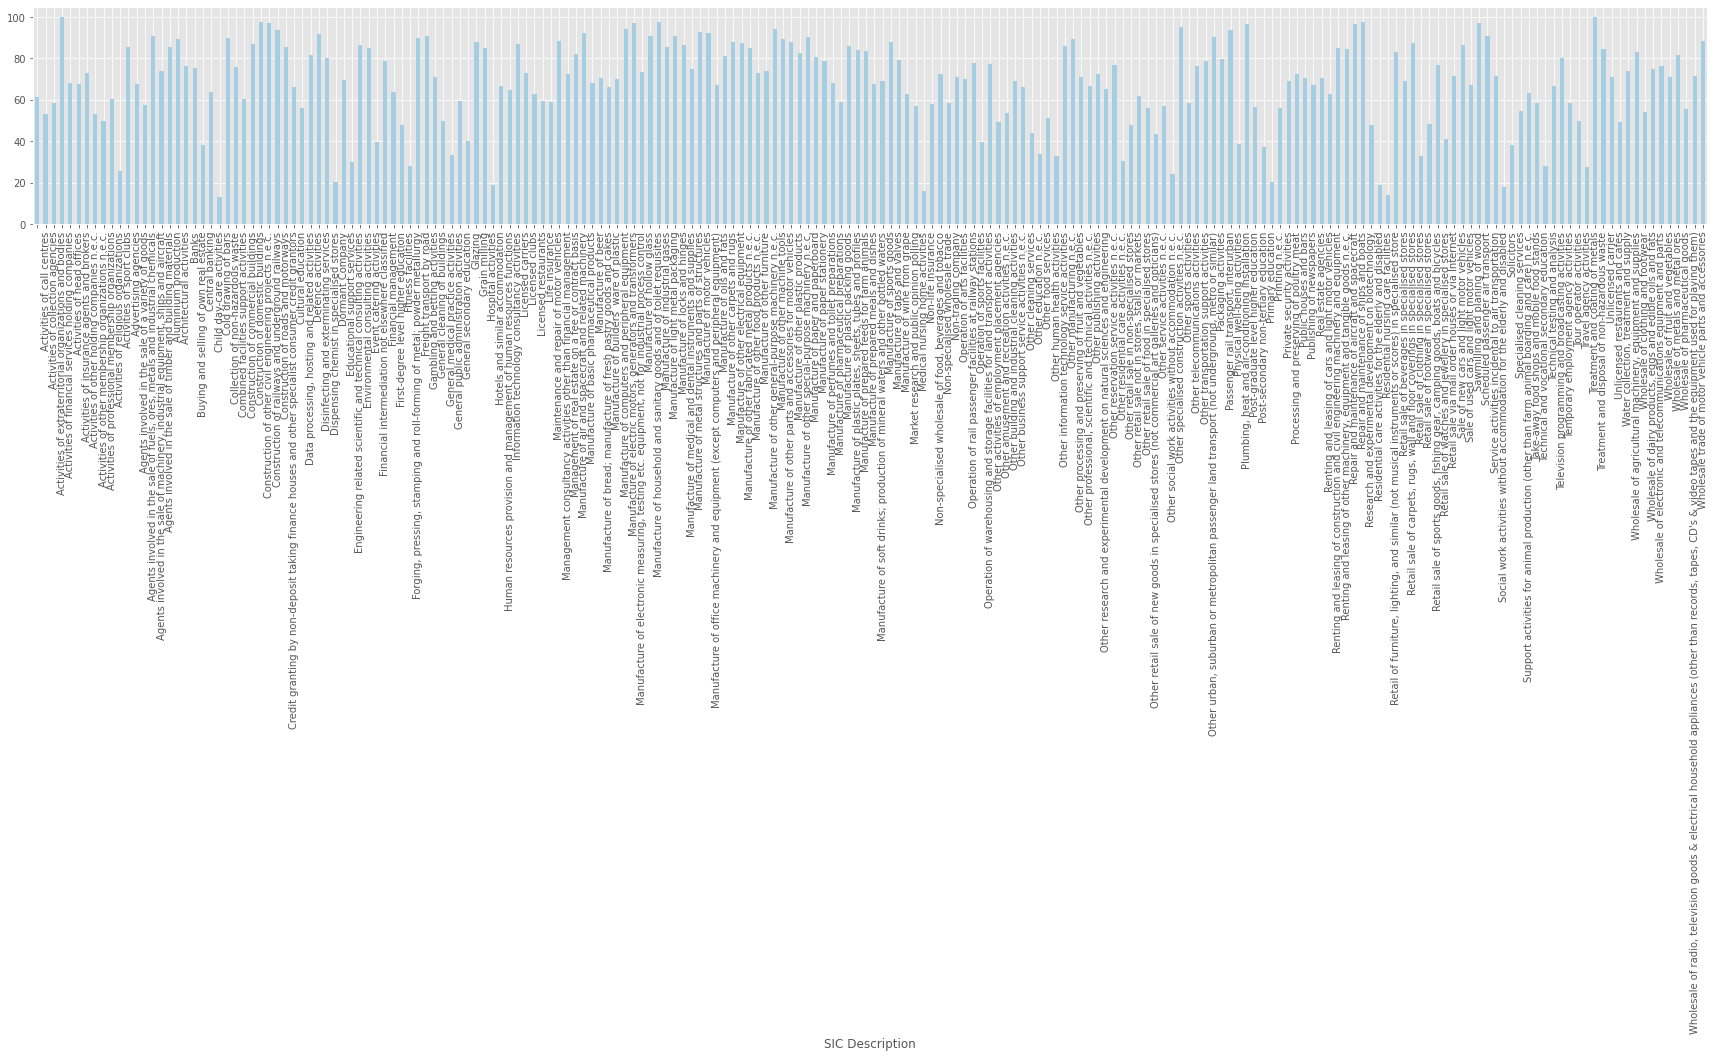

In [19]:
# MALE EMPLOYEES IN THE TOP QUARTILE 
sector_meanwage = data.groupby('SIC Description')['Male top quartile %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors with the most male employees in the top is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors with the least male employees in the top is:\n', low_sectors)

Not surprisingly, men are most present in the top quartile in sectors like 'Activities of extraterritorial organizations and bodies' and 'Treatment and coating of metals' while the top 5 sectors there is least is sectors like, 'Child day-care activities' and 'Medical nursing home activities'. 
This adds up with out plot for the distribution of women in the top quartile.

It is worth noticing that the top 5 of companies with the least men in the top quartile in the top still has around 10-15 % men with 13,2 % being the lowest, while the top 5 companies with the least women in the top quartile only reaches 2.5 % with the top 2 ('Activities of extraterritorial organizations and bodies' & 'Treatment and coating of metals') having 0 female employees, and both making it into the top 5 of companies paying men more. 

This insinuates that the wage gap might also have it's roots in the fact that more men than women are in top positions of companies.

Lets look at the bottom quartile portion of men. 

The top 5 sectors with the most male employees in the bottom is:
 SIC Description
Forging, pressing, stamping and roll-forming of metal; powder metallurgy        95.0
Retail sale of carpets, rugs, wall and floor coverings in specialised stores    94.3
Treatment and disposal of non-hazardous waste                                   92.3
Construction of domestic buildings                                              89.8
Manufacture of light metal packaging                                            89.5
Name: Male bottom quartile %, dtype: float64 

The top 5 sectors with the least male employees in the bottom is:
 SIC Description
Treatment and coating of metals                                0.000
Retail sale of watches and jewellery in specialised stores     6.000
Child day-care activities                                      6.175
Event catering activities                                      9.900
Residential nursing care facilities                           13.740
Name: Male bottom 

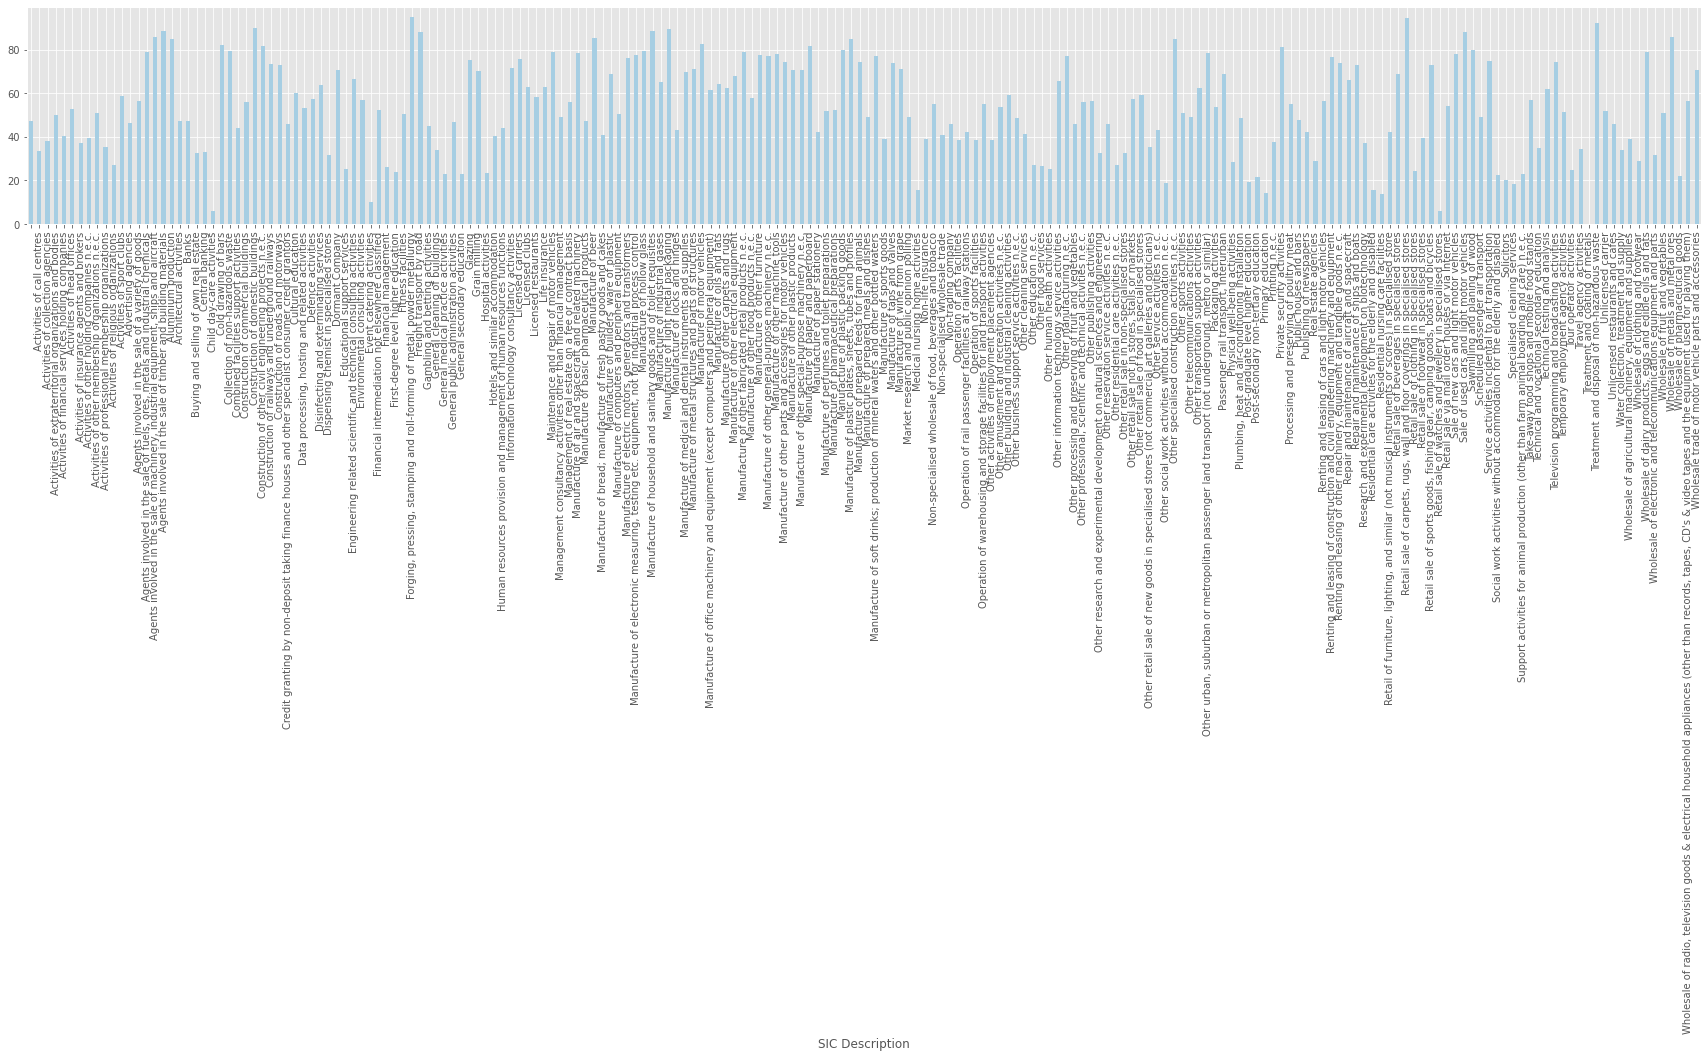

In [20]:
# MALE EMPLOYEES IN THE BOTTOM QUARTILE 
sector_meanwage = data.groupby('SIC Description')['Male bottom quartile %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors with the most male employees in the bottom is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors with the least male employees in the bottom is:\n', low_sectors)

Same gendered pattern shows here. Men are almost not present at all in caring and hospitality sectors like 'Child day-care activities' with 6,2% men employed in the bottom quartile even though they are taking up 13,2 % of the positions in the top in the same sector. This is pointing at a misalignment in the distribution of promotions within the companies. 

They are most present in sectors like, 'Forging, pressing, stamping and roll-forming of metal; powder metallurgy', 'Treatment and disposal of non-hazardous waste' and 'Construction of domestic buildings', which points back to the negative values, we got when we grouped the mean wage differences based on the sectors. This suggests that in these sectors there is a few women in the top positions earning way more then the average worker in these sectors, even though these sectors doesn't show when we are grouping the amount of female employees in the top quartile. 

This aligns with the fact that the mean wage difference was way higher when the men earned more on a average then when it was women earning the most. 

# MEDIAN WAGE DIFFERENCE 
The data dataframe provides us with both the mean and median values of the wage gap, as the mean is the average wage gap between all values and the median is the middle value of all the wage gaps. 

If the median difference in the wage is very different from the mean it can indicate that there might be some extreme values at either end of the scale that differ quite from the other values. 

Therefore, I am going to have a quick look at the median wage gap grouped by sectors. 

The top 5 sectors with the biggest median wage difference is:
 SIC Description
Activities of extraterritorial organizations and bodies              64.80
Treatment and coating of metals                                      61.30
Plumbing, heat and air-conditioning installation                     48.90
Wholesale of electronic and telecommunications equipment and parts   37.80
Repair and maintenance of ships and boats                            37.00
Name: Median wage difference %, dtype: float64 

The top 5 sectors with the smallest median wage difference is:
 SIC Description
Forging, pressing, stamping and roll-forming of metal; powder metallurgy   -48.10
Manufacture of beer                                                        -23.00
Fitness facilities                                                         -20.10
Manufacture of household and sanitary goods and of toilet requisites       -17.70
Licensed carriers                                                          -17.00
Name: M

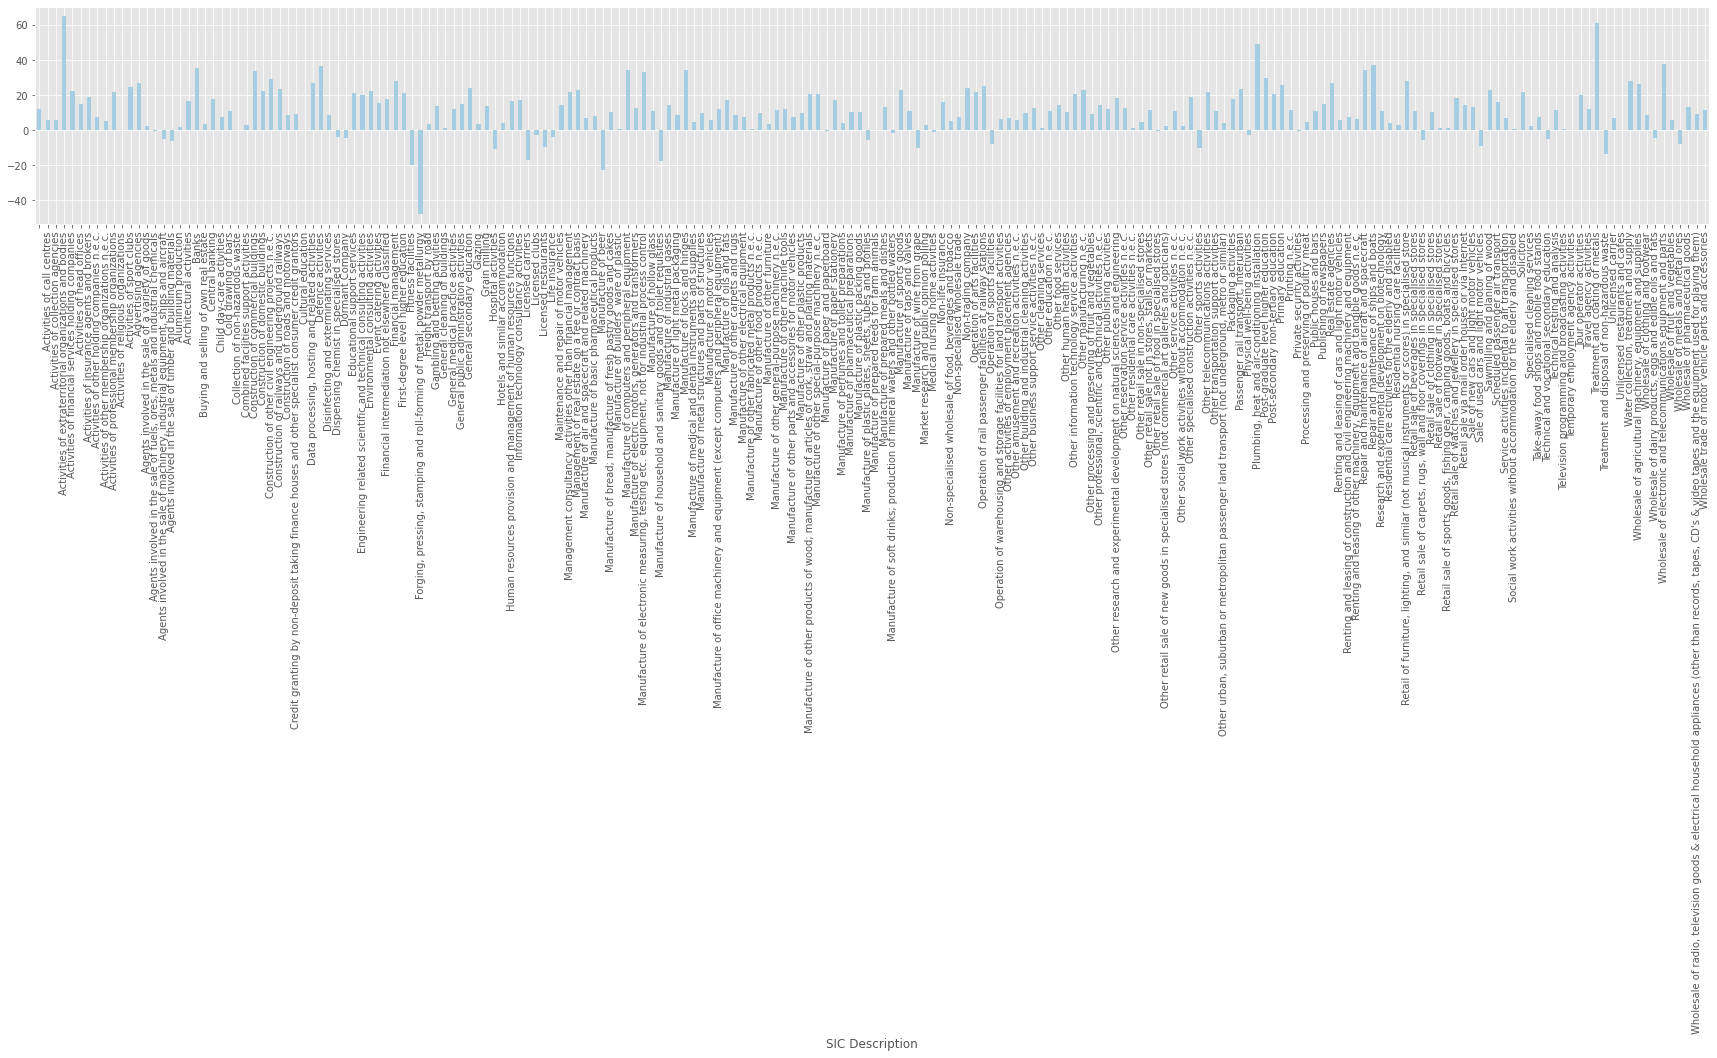

In [61]:
# MEDIAN WAGE DIFFERENCE 
sector_meanwage = data.groupby('SIC Description')['Median wage difference %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors with the biggest median wage difference is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors with the smallest median wage difference is:\n', low_sectors)


Okay, so the results for the sectors in which the average wage gap is biggest are quite similar in general.

However, the sector 'Activities of sport clubs', which was the sector with the biggest mean wage difference is not present at all in the top 5 over the biggest median wage difference. This indicates that there is a concentration of high wages in one end with the rest of the wages being more or less evenly spread out in the 'Activities of sport clubs' - meaning a few men are getting most of the money. 

We are also again getting negative values in the sectors where the median wage gap is smallest aligning with our mean wage distribution, but the sector,'Forging, pressing, stamping and roll-forming of metal; powder metallurgy' being the only recurrent one, indicating that the wage gap distribution is not symmetrical in the dataset. 

This indicates that

Another really interesting factor - maybe even more so than the wage gap - is the differences in bonus levels, as this is often distributed based on the way you perform within the organisation and often on the individual's interpersonal relations - it is often less restricted and can be given out more or less freely based on the boss's wishes and wants and thereby point to the structures and the inequality within an organisation. 



The top 5 sectors where the biggest amount of women were paid a bonus is:
 SIC Description
Cold drawing of bars                                           100.0
Manufacture of electric motors, generators and transformers    100.0
Scheduled passenger air transport                               99.0
Wholesale of agricultural machinery, equipment and supplies     96.5
Aluminium production                                            96.2
Name: Female bonus %, dtype: float64 

The top 5 sectors where the smallest amount of women were paid a bonus is:
 SIC Description
Activities of extraterritorial organizations and bodies                               0.0
Agents involved in the sale of machinery, industrial equipment, ships and aircraft    0.0
Central banking                                                                       0.0
Child day-care activities                                                             0.0
Disinfecting and exterminating services                                  

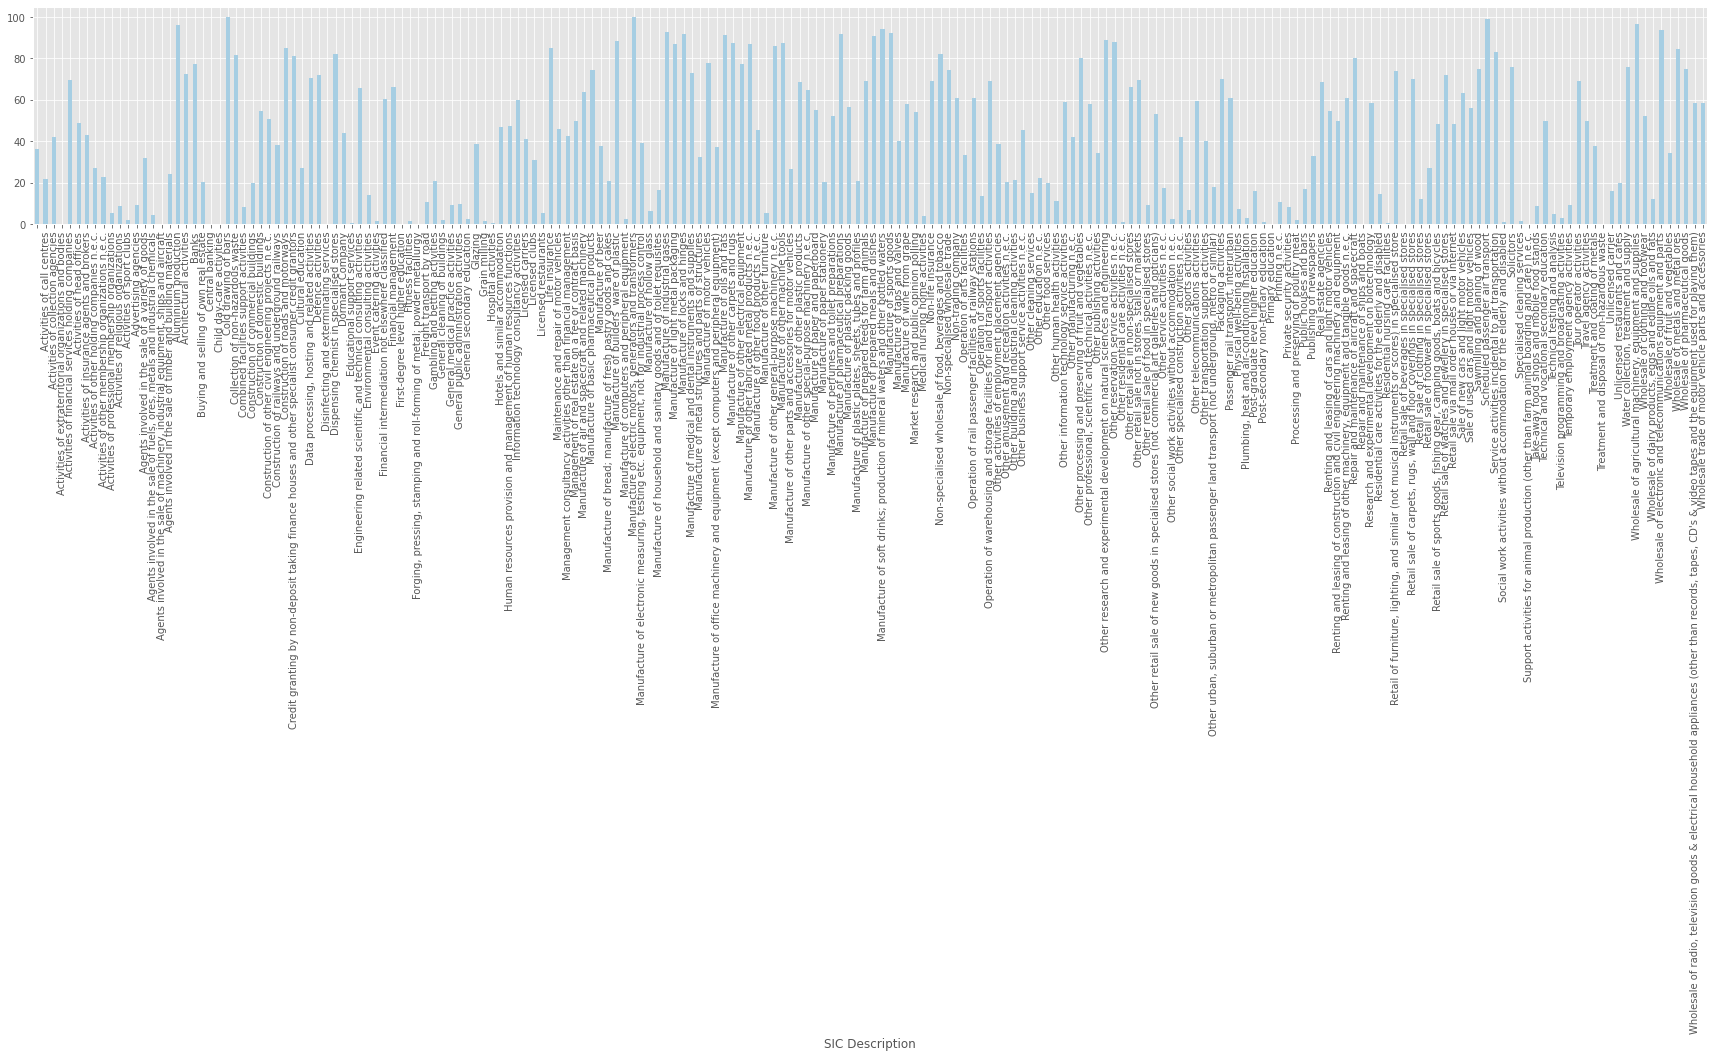

In [22]:
# FEMALE BONUS
sector_meanwage = data.groupby('SIC Description')['Female bonus %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors where the biggest amount of women were paid a bonus is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors where the smallest amount of women were paid a bonus is:\n', low_sectors)

The one sector were no women were paid a bonus is 'Activities of extraterritorial organizations and bodies' which was also in the top 5 of the sectors with the biggest wage gap. 

It is also interesting that no women were paid a bonus in the sector, 'Child day-care activities' were they are very present. This could be indicating internal discrimation in the company, which would align with how the men in the top and the bottom quartile are distributed as we discovered earlier. 

Lets look at the men. 

The top 5 sectors where the biggest amount of men were paid a bonus is:
 SIC Description
Manufacture of electric motors, generators and transformers    99.6
Cold drawing of bars                                           99.3
Scheduled passenger air transport                              98.0
Aluminium production                                           97.5
Wholesale of agricultural machinery, equipment and supplies    97.2
Name: Male bonus %, dtype: float64 

The top 5 sectors where the smallest amount of men were paid a bonus is:
 SIC Description
Central banking                                                             0.0
Child day-care activities                                                   0.0
First-degree level higher education                                         0.0
Forging, pressing, stamping and roll-forming of metal; powder metallurgy    0.0
Primary education                                                           0.0
Name: Male bonus %, dtype: float64


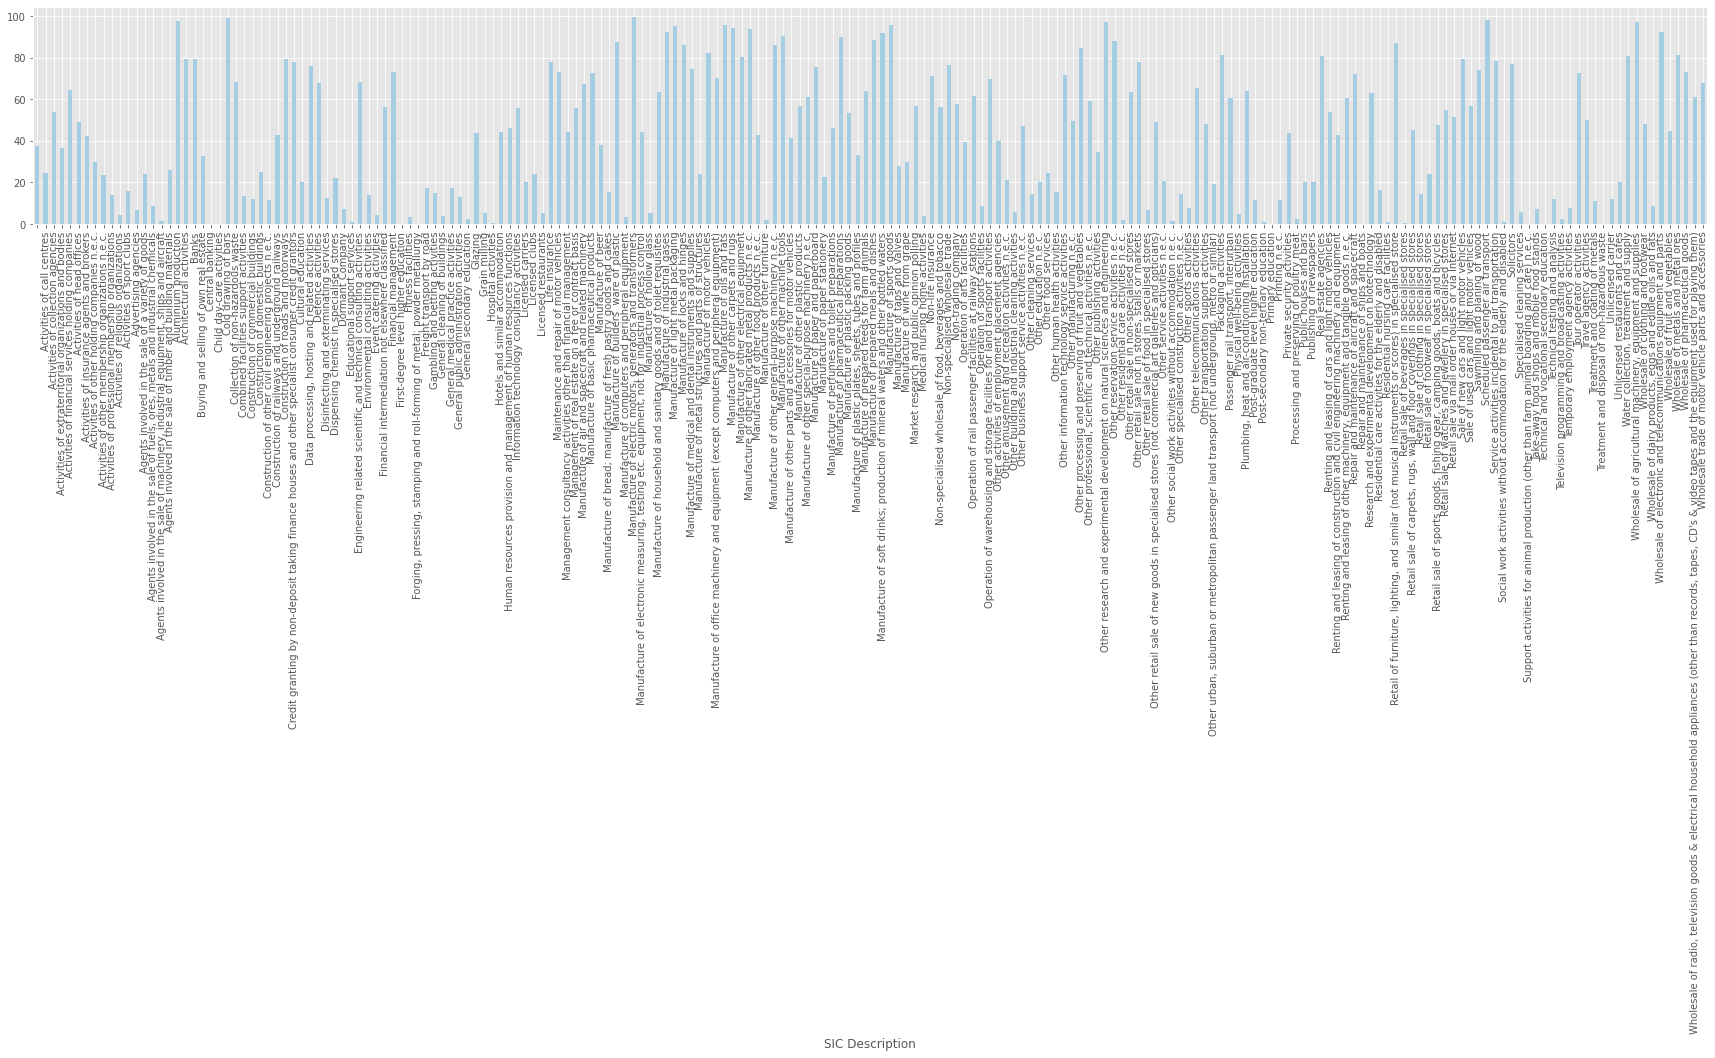

In [23]:
# MALE BONUS 
sector_meanwage = data.groupby('SIC Description')['Male bonus %'].mean()
sector_meanwage.plot(kind='bar', stacked = 'true', colormap = 'Paired', figsize=(30, 4))

top_sectors = sector_meanwage.nlargest(5)
print('The top 5 sectors where the biggest amount of men were paid a bonus is:\n', top_sectors,'\n')

low_sectors = sector_meanwage.nsmallest(5)
print('The top 5 sectors where the smallest amount of men were paid a bonus is:\n', low_sectors)


The interesting thing here is that there is a total overlap in the sectors where most men and women get bonusses with all of them being close to or at a 100 %. This is indicating that some sectors might also have different systems for bonus practices than others. 
The same point applies to the overlaps in the sectors where the least men and women were paid a bonus, these sectors being 'Central banking' and 'Child day-care activities' and the amount being 0. This rule out my theory that there was discrimination or favoritism going on in terms of the bonusses in the Child day-care activities' sectors from the previous cell. 

So there is some patterns present here. We have seen some sectors being in the top of the wage gap and also being present in the top 5 of the companies hiring the least women in the top or the most women in the bottom. 

To look further into this, I am gonna first predict the correlation between some of these variables. 

# CORRELATIONS 





In [24]:
# only look at part of the data
relevant_cols = ['Mean wage difference %', 'Median wage difference %', 'Male bonus %', 'Female bonus %','Female top quartile %','Male top quartile %','Female bottom quartile %','Male bottom quartile %']
relevant_cols = data[relevant_cols]
relevant_cols_corr = relevant_cols.corr()
relevant_cols_corr.style.background_gradient(cmap='coolwarm').set_precision(2)


<ipython-input-24-e95c010c53f3>:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  relevant_cols_corr.style.background_gradient(cmap='coolwarm').set_precision(2)


The prediction map here shows a few interesting things: 
 
That between both female and male bonusses seems to be negatively correlated with the numbers for women both in the top and the bottom of the quartile, while the female and male bonusses are positively correlated with the men in the bottom and the top. 
This indicates that the more female employees there are in the top, the bonus for both men and women decreases, while the reverse is true for the men. 

This could be because of the same thing we saw before with the 'Child day-care activities' -> that men seem to be in the top in sectors where more bonusses are given. 


There also, interestingly, seems to be a positive correlation between percentage of female employees in the bottom and in the top, while the percentage of female employees in the top and the bottom seem to be negatively correlated with the percentage of male employees in the top and the bottom.

This is a pointing very clearly to the thing that we discovered in the previous cells: That a lot of the sectors are actually very gendered, and that if there is a lot of female employees in the top, there might also be a lot in the bottom, and chances that it is a caring or hospitality sector is high. 

The same pattern when we see that the variable, Male top quartile % seems to be negatively correlated with the variable, 'Female top quartile %', meaning that the more men in the top quartile the less is the changes that there will be any female employees at all, and the same with 'Female top quartile %' and 'Male top quartile %'. 

However, it could also point to the fact that men might hire men and that women are better at gender distribution. 

I am going to plot some of these variables to see if the prediction is right. 

Most of the code from the correlations are taken from the 'Week 4: regression' class notebook. 

-1.0 100.0 -1.0


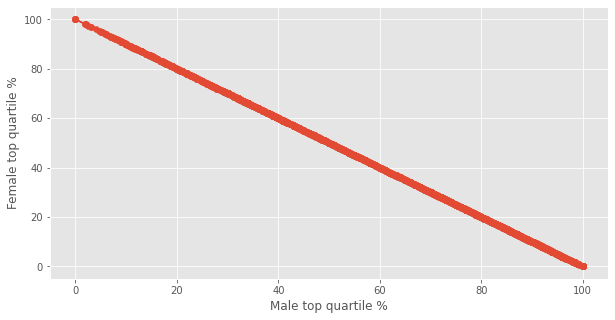

In [108]:
# PLOTTING THE VARIABLES 
d = data[["Male top quartile %",'Female top quartile %']].values
x = d[:,0]    
y = d[:,1]   
pd.set_option('display.float_format','{:.2f}'.format)   
np.set_printoptions(suppress=True)

def plot_scatter(x,y,xlabel,ylabel):
    fig,ax = plt.subplots(figsize = (10,5))
    ax.scatter(x,y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style='plain')
    return ax

# FITTING THE LINEAR MODEL 
slope, intercept, r, p, std_err = st.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]            # this is our function

ax = plot_scatter(x,y,"Male top quartile %",'Female top quartile %')
ax.plot(x, model_y)
print(slope,intercept,r)


Uncanny stuff. 

This shows a total linear regression model, f(x) = -1x + 100 with the independent variable, x = "Male top quartile %" and the dependent variable being, f(x) = 'Female top quartile % and the r-value = -1. 

This shows that everytime one man gets into the top quartile, one women gets pushed out.

Another almost as clear cut prediction of relationship is the one that female and male top and female and male bottom. 

-0.7610539 99.27230326059102 -0.7661181934322971


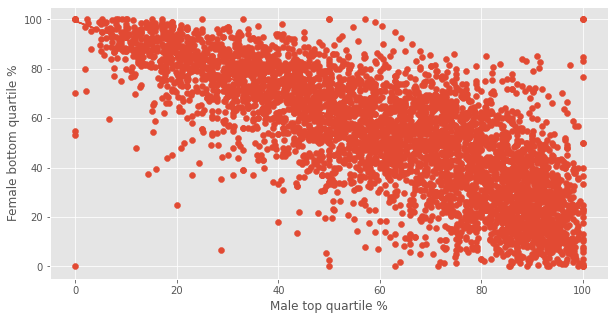

In [109]:
# PLOTTING THE VARIABLES 
d = data[["Male top quartile %",'Female bottom quartile %']].values
x = d[:,0]    
y = d[:,1]   
pd.set_option('display.float_format','{:.2f}'.format)   
np.set_printoptions(suppress=True)

def plot_scatter(x,y,xlabel,ylabel):
    fig,ax = plt.subplots(figsize = (10,5))
    ax.scatter(x,y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style='plain')
    return ax

# FITTING THE LINEAR MODEL 
slope, intercept, r, p, std_err = st.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]            # this is our function

ax = plot_scatter(x,y,"Male top quartile %",'Female bottom quartile %')
ax.plot(x, model_y)
print(slope,intercept,r)


This shows a total linear regression model, f(x) = -0.76x + 99.3 with the independent variable, x = "Male top quartile %" and the dependent variable being, f(x) = 'Female bottom quartile % and the r-value = -0.78 

This shows that everytime the more men in top the more the amount of women in the bottom decreases. 

We saw that from the cells before that there was an overlap with in the sectors with the least female employees in the top and the biggest wage gaps. This indicates a correlation between the amount of male employees in the top and the wage gap. Lets see:  

0.10138116 7.635156180887211 0.1759911137697087


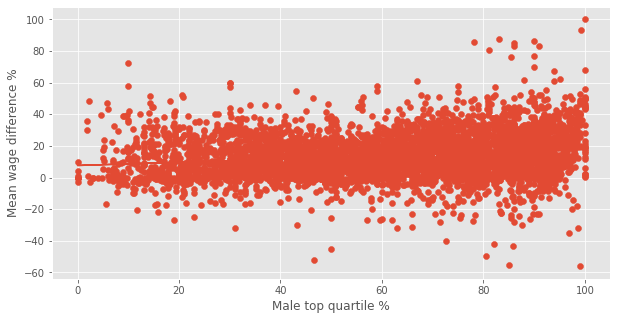

In [112]:
# PLOTTING THE VARIABLES 
d = data[['Male top quartile %','Mean wage difference %']].values
x = d[:,0]    
y = d[:,1]   
pd.set_option('display.float_format','{:.2f}'.format)   
np.set_printoptions(suppress=True)

def plot_scatter(x,y,xlabel,ylabel):
    fig,ax = plt.subplots(figsize = (10,5))
    ax.scatter(x,y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.ticklabel_format(style='plain')
    return ax

# FITTING THE LINEAR MODEL 
slope, intercept, r, p, std_err = st.linregress(x, y)
slope = np.float32(slope)
model_y = [slope * i + intercept for i in x]            # this is our function

ax = plot_scatter(x,y,"Male top quartile %",'Mean wage difference %')
ax.plot(x, model_y)
print(slope,intercept,r)


The plot indicates that a linear model might not be the best to describe the relationship between these variables. 


So I will plot it again, using numpys polyfit to see if a polynomial model would be good and if there is any correlation

In [113]:
# get the variables
x = (data["Male top quartile %"].values)
y = (data["Mean wage difference %"].values)

           10             9             8             7             6
3.114e-15 x  - 1.517e-12 x + 3.128e-10 x - 3.539e-08 x + 2.376e-06 x
              5            4           3             2
 - 9.534e-05 x + 0.002156 x - 0.02234 x + 0.0002087 x + 1.501 x + 5.132


r2 = 0.051512391729578444


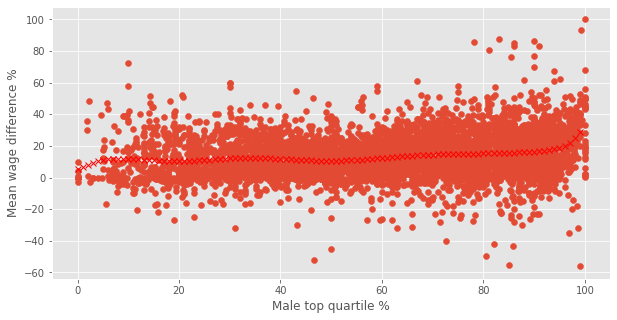

In [114]:
#CHANGE THIS!
num_degrees = 10
#Fit model
poly_model = np.polyfit(x, y, num_degrees)
poly_model = np.poly1d(poly_model)

#Get r2 score
r2 = r2_score(y, poly_model(x))

#Plot
ax = plot_scatter(x,y,"Male top quartile %","Mean wage difference %")
model_x = np.arange(np.max(x))
model_y = poly_model(model_x)
ax.plot(model_x,model_y,"rx")

print(poly_model)           # print the actual model 
print("\n")
print("r2 =",r2)

Okay, so I tried a lot of different degrees of polynomial models, also doesn't seem to be the right model to describe. The prediction also only hit a 0.18 so chances were also not that high. 

Instead, I am going to visualize the data to see if that can give reveal any patterns or relationsships. 

Code in following cell taking from 'Week 7 - Data visualization' class notebook. 

In [90]:
import pandas as pd
import plotly.graph_objs as go

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=data['Female top quartile %'],
                                   y=data['Mean wage difference %'],
                                   z=data['Male top quartile %'],
                                   mode='markers',
                                   marker=dict(
                                       size=3, 
                                       color=data['Mean wage difference %'],                                  
                                       colorscale='Rainbow', 
                                       opacity=0.8))])

# Set the title and axis labels
fig.update_layout(title='UK wage gap',
                  scene=dict(xaxis_title='Female top quartile %',
                             yaxis_title='Mean wage gaps %',
                             zaxis_title='Male top quartile %'),
                             margin=dict(l=0, r=0, t=40, b=0))

# Show the plot
fig.show()

We see that the amount of men in the top quartile are completely negatively correlated to the amount of women in the top quartile - resulting in our our very nicely and clean distributed data points in the 3D visualization. 

All of this points to the fact that men are most present in the top quartile of all sectors. There is an overlap in sectors from which there was the least amount of female employees in the top and the one with the biggests wage gaps, and a tendency that men are more present in the top quartile than in the bottom, indicating that they get more promotions. 

However, the sectors with the least men in the top and the plots on bonusses given to men and women also show that the sectors are in general really gendered, and that what is usually associated with 'traditionally male and female occupations and industries' also is relfected in real life. 

## ETHICS 

Another pattern I see in the data is how white it is - or rather how there is no data on race, queerness and neurodivergence in the data. 

It could be interesting to see how many of the employees in the bottom quartile are POC and how many people in the top quartile that are white. 
How many white people get a bonus compared to how many Black and Brown people.
There has historically been a tendency that white men and women earned more than POC men and women, but we can't not read from this data. 

It is erasing the gaps and discrimination that would become apparent if you were to look at the pay gap between white people and POC and Black people as well as nonbinary and gendernonconforming people. 

Therefore, it is harmful to see this data as the only and the full picture, as it erase the inequality in all the other intersections like race, non-conforming genders, neurodivergence eg. 

It also taps into the discussions on why we should care *that* much about the  wage gap between men and women in UK-based companies that are build upon structures of white supremacy and colonialism? Our hardware, our clothes and our lentils and vegetables are produced in the global south exploiting workers, especially women working. Thinking that the fight for gender equality lies on the wage gap in the UK and especially lying in the top quartile is restrictive and problematic. 

To view this data as reflecting the issues between working people is restrictive, because how does it help women in the Global South that there are more white women in top positions? How does it help working class women struggling to make ends meet that there are more white women in top positions getting bonusses? 
And how does it help nonbinary, trans and gendernonconforming people that there are more white women getting higher wages when they are not even a category.